In [369]:
import os 
import numpy as np 
import cv2
from glob import glob
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [370]:
os.environ["PYTHONHASHSEED"]= str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [371]:
batch_size=8
lr=0.0001
epoch=100
height=128
width=128

In [372]:
dataset_path = os.path.join("dataset2", "non-aug")
files_dir= os.path.join("files", "non-aug")
model_file=os.path.join(files_dir, "unet-non-aug.h5")
log_file=os.path.join(files_dir, "log-non-aug.csv")

In [373]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_dir(files_dir)

In [374]:
def conv_block(inputs, num_filters):
    x= Conv2D(num_filters, 3, padding="same")(inputs)
    x= BatchNormalization()(x)
    x=Activation('relu')(x)

    x=Conv2D(num_filters, 3, padding="same")(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    return x

In [375]:
def encoder_block(inputs, num_filters):
    x= conv_block(inputs, num_filters)
    p=MaxPool2D((2,2))(x)
    return x,p

In [376]:
def decoder_block(inputs, skip, num_filters):
    x=Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
    x= Concatenate()([x,skip])
    x= conv_block(x,num_filters)
    return x

In [377]:
def build_unet(input_shape):
    inputs =Input(input_shape)
    s1,p1=encoder_block(inputs,64)
    s2,p2=encoder_block(p1, 128)
    s3,p3=encoder_block(p2,512)
    s4,p4=encoder_block(p3,512)
    b1= conv_block(p4, 1024)

    d1=decoder_block(b1,s4,512)
    d2=decoder_block(d1,s3,256)
    d3=decoder_block(d2,s2,128)
    d4=decoder_block(d3,s1,64)
    outputs= Conv2D(1,1, padding="same", activation="sigmoid")(d4)
    model= Model(inputs, outputs, name="UNET")
    return model

In [378]:
def load_data(path):
    train_x= sorted(glob(os.path.join(path, "train", "images", "*" )))
    train_y= sorted(glob(os.path.join(path, "train", "masks", "*" )))
    test = sorted(glob(os.path.join(path, "test", "*" )))
    valid_x= sorted(glob(os.path.join(path, "valid", "images", "*" )))
    valid_y= sorted(glob(os.path.join(path, "valid", "masks", "*" )))

    return (train_x, train_y), (valid_x, valid_y) , test

In [379]:
def read_image(path):
    path=path.decode()
    x=cv2.imread(path, cv2.IMREAD_COLOR)
    x=x/255.0
    return x

In [380]:
def read_mask(path):
    path=path.decode()
    x=cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x=x/255.0
    x=np.expand_dims(x,axis=-1)
    return x

In [381]:
def tf_parse(x,y):
    def _parse(x,y):
        x= read_image(x)
        y= read_mask(y)
        return x,y
    x,y =tf.numpy_function(_parse, [x,y], [tf.float64,tf.float64])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])
    return x,y

In [382]:
def tf_dataset(x,y, batch=8):
    dataset= tf.data.Dataset.from_tensor_slices((x,y))
    dataset= dataset.map(tf_parse,num_parallel_calls=tf.data.AUTOTUNE)
    dataset=dataset.batch(batch)
    dataset= dataset.prefetch(tf.data.AUTOTUNE)
    return dataset



In [383]:
(train_x, train_y), (valid_x, valid_y),test= load_data(dataset_path)

print("train" , len(train_x), len(train_y))
print("valid" , len(valid_x), len(valid_y))
print("test" , len(test))

train 75 75
valid 26 26
test 75


In [384]:


train_dataset= tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset= tf_dataset(valid_x, valid_y, batch=batch_size)



In [385]:
input_shape = (height, width, 3)
model= build_unet(input_shape)

In [386]:
model.summary()

opt=tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_190 (Conv2D)            (None, 128, 128, 64  1792        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_180 (Batch  (None, 128, 128, 64  256        ['conv2d_190[0][0]']             
 Normalization)                 )                                                              

In [387]:
callbacks=[

    ModelCheckpoint(model_file, verbose=1, save_best_only=True), 
    ReduceLROnPlateau(monitor='val_loss', factor=.1, patience=4),
    CSVLogger(log_file), 
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

In [388]:
model.fit(
    train_dataset, validation_data=valid_dataset, epochs=epoch, callbacks=callbacks
)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.3650 - accuracy: 0.9095
Epoch 1: val_loss improved from inf to 0.66183, saving model to files/non-aug/unet-non-aug.h5
10/10 [==============================] - 4s 226ms/step - loss: 0.3650 - accuracy: 0.9095 - val_loss: 0.6618 - val_accuracy: 0.9846 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9539
Epoch 2: val_loss improved from 0.66183 to 0.61687, saving model to files/non-aug/unet-non-aug.h5
10/10 [==============================] - 2s 184ms/step - loss: 0.2118 - accuracy: 0.9539 - val_loss: 0.6169 - val_accuracy: 0.9722 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9635
Epoch 3: val_loss improved from 0.61687 to 0.57434, saving model to files/non-aug/unet-non-aug.h5
10/10 [==============================] - 2s 191ms/step - loss: 0.1753 - accuracy: 0.9635 - val_loss: 0.5743 - val_accuracy: 0.921

In [394]:

save_path= "prediction,non-aug"


create_dir(save_path)

model2=tf.keras.models.load_model(model_file)
model2.summary()


test_x=sorted(os.path.join(dataset_path, 'test', "*"))

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_190 (Conv2D)            (None, 128, 128, 64  1792        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_180 (Batch  (None, 128, 128, 64  256        ['conv2d_190[0][0]']             
 Normalization)                 )                                                              

In [395]:
test_x=sorted(glob(os.path.join("/home/keanuf/.cache/Assignemt9/BRAIN SEGMENTATION/dataset2/non-aug/", "test","*")))
test_x[0]

'/home/keanuf/.cache/Assignemt9/BRAIN SEGMENTATION/dataset2/non-aug/test/353340_10.png'

In [396]:
time_taken=[]
import time
for x in tqdm(test_x):
    name=x.split("/")[-1]
    print(name)
    x= cv2.imread(x ,cv2.IMREAD_COLOR)
    x=x / 255.0
    x=np.expand_dims(x,axis=0)
    start_time=time.time()
    p= model.predict(x)[0]
    total_time=time.time()-start_time
    time_taken.append(total_time)
    p=p>0.5
    p=p*255
    cv2.imwrite(os.path.join(save_path, name),p)

   



  0%|          | 0/615 [00:00<?, ?it/s]

353340_10.png
1/1 [==============================] - 0s 27ms/step
353340_11.png
1/1 [==============================] - 0s 20ms/step


  0%|          | 2/615 [00:00<00:41, 14.75it/s]

353340_12.png
1/1 [==============================] - 0s 26ms/step
353340_13.png
1/1 [==============================] - 0s 25ms/step


  1%|          | 4/615 [00:00<00:41, 14.88it/s]

353340_14.png
1/1 [==============================] - 0s 23ms/step
353340_15.png
1/1 [==============================] - 0s 26ms/step


  1%|          | 6/615 [00:00<00:40, 15.05it/s]

353340_16.png
1/1 [==============================] - 0s 21ms/step
353340_17.png
1/1 [==============================] - 0s 21ms/step


  1%|▏         | 8/615 [00:00<00:40, 14.95it/s]

353340_18.png
1/1 [==============================] - 0s 19ms/step
353340_19.png
1/1 [==============================] - 0s 20ms/step


  2%|▏         | 10/615 [00:00<00:39, 15.13it/s]

353340_20.png
1/1 [==============================] - 0s 32ms/step
353340_21.png
1/1 [==============================] - 0s 22ms/step


  2%|▏         | 12/615 [00:00<00:40, 15.01it/s]

353340_22.png
1/1 [==============================] - 0s 24ms/step
353340_23.png
1/1 [==============================] - 0s 24ms/step


  2%|▏         | 14/615 [00:00<00:40, 14.92it/s]

353340_24.png
1/1 [==============================] - 0s 25ms/step
353340_25.png
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 16/615 [00:01<00:39, 15.04it/s]

353340_26.png
1/1 [==============================] - 0s 24ms/step
353340_27.png
1/1 [==============================] - 0s 22ms/step


  3%|▎         | 18/615 [00:01<00:39, 15.03it/s]

353340_28.png
1/1 [==============================] - 0s 27ms/step
353340_29.png
1/1 [==============================] - 0s 27ms/step


  3%|▎         | 20/615 [00:01<00:39, 15.05it/s]

353340_30.png
1/1 [==============================] - 0s 21ms/step
353340_31.png
1/1 [==============================] - 0s 19ms/step


  4%|▎         | 22/615 [00:01<00:39, 15.10it/s]

353340_32.png
1/1 [==============================] - 0s 28ms/step
353340_33.png
1/1 [==============================] - 0s 26ms/step


  4%|▍         | 24/615 [00:01<00:44, 13.17it/s]

353340_34.png
1/1 [==============================] - 0s 25ms/step
353340_35.png
1/1 [==============================] - 0s 26ms/step


  4%|▍         | 26/615 [00:01<00:43, 13.40it/s]

353340_36.png
1/1 [==============================] - 0s 24ms/step
353340_37.png
1/1 [==============================] - 0s 29ms/step


  5%|▍         | 28/615 [00:01<00:41, 13.98it/s]

353340_38.png
1/1 [==============================] - 0s 22ms/step
353340_39.png
1/1 [==============================] - 0s 28ms/step


  5%|▍         | 30/615 [00:02<00:41, 14.11it/s]

353340_40.png
1/1 [==============================] - 0s 33ms/step
353340_41.png
1/1 [==============================] - 0s 23ms/step


  5%|▌         | 32/615 [00:02<00:40, 14.46it/s]

353340_42.png
1/1 [==============================] - 0s 26ms/step
353340_43.png
1/1 [==============================] - 0s 22ms/step


  6%|▌         | 34/615 [00:02<00:39, 14.71it/s]

353340_44.png
1/1 [==============================] - 0s 21ms/step
353340_45.png
1/1 [==============================] - 0s 24ms/step


  6%|▌         | 36/615 [00:02<00:39, 14.77it/s]

353340_46.png
1/1 [==============================] - 0s 21ms/step
353340_47.png
1/1 [==============================] - 0s 21ms/step


  6%|▌         | 38/615 [00:02<00:38, 15.02it/s]

353340_48.png
1/1 [==============================] - 0s 22ms/step
353340_49.png
1/1 [==============================] - 0s 23ms/step


  7%|▋         | 40/615 [00:02<00:38, 14.93it/s]

353340_50.png
1/1 [==============================] - 0s 21ms/step
353340_51.png
1/1 [==============================] - 0s 25ms/step


  7%|▋         | 42/615 [00:02<00:38, 14.94it/s]

353340_52.png
1/1 [==============================] - 0s 27ms/step
353340_53.png
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 44/615 [00:02<00:38, 14.95it/s]

353340_54.png
1/1 [==============================] - 0s 23ms/step
353340_55.png
1/1 [==============================] - 0s 20ms/step


  7%|▋         | 46/615 [00:03<00:37, 15.05it/s]

353340_56.png
1/1 [==============================] - 0s 23ms/step
353340_57.png
1/1 [==============================] - 0s 20ms/step


  8%|▊         | 48/615 [00:03<00:36, 15.47it/s]

353340_58.png
1/1 [==============================] - 0s 22ms/step
353340_59.png
1/1 [==============================] - 0s 41ms/step


  8%|▊         | 50/615 [00:03<00:38, 14.83it/s]

353340_60.png
1/1 [==============================] - 0s 28ms/step
353340_61.png
1/1 [==============================] - 0s 26ms/step


  8%|▊         | 52/615 [00:03<00:40, 13.87it/s]

353340_62.png
1/1 [==============================] - 0s 21ms/step
353340_63.png
1/1 [==============================] - 0s 28ms/step


  9%|▉         | 54/615 [00:03<00:39, 14.13it/s]

353340_64.png
1/1 [==============================] - 0s 25ms/step
353340_65.png
1/1 [==============================] - 0s 22ms/step


  9%|▉         | 56/615 [00:03<00:39, 14.21it/s]

353340_66.png
1/1 [==============================] - 0s 27ms/step
353340_67.png
1/1 [==============================] - 0s 24ms/step


  9%|▉         | 58/615 [00:03<00:38, 14.48it/s]

353340_68.png
1/1 [==============================] - 0s 20ms/step
353340_69.png
1/1 [==============================] - 0s 20ms/step


 10%|▉         | 60/615 [00:04<00:37, 14.69it/s]

353340_7.png
1/1 [==============================] - 0s 28ms/step
353340_70.png
1/1 [==============================] - 0s 22ms/step


 10%|█         | 62/615 [00:04<00:37, 14.85it/s]

353340_71.png
1/1 [==============================] - 0s 37ms/step
353340_72.png
1/1 [==============================] - 0s 29ms/step


 10%|█         | 64/615 [00:04<00:40, 13.77it/s]

353340_73.png
1/1 [==============================] - 0s 21ms/step
353340_74.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 66/615 [00:04<00:38, 14.17it/s]

353340_75.png
1/1 [==============================] - 0s 26ms/step
353340_76.png
1/1 [==============================] - 0s 21ms/step


 11%|█         | 68/615 [00:04<00:37, 14.47it/s]

353340_77.png
1/1 [==============================] - 0s 22ms/step
353340_78.png
1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 70/615 [00:04<00:37, 14.63it/s]

353340_79.png
1/1 [==============================] - 0s 20ms/step
353340_8.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 72/615 [00:04<00:36, 15.02it/s]

353340_80.png
1/1 [==============================] - 0s 20ms/step
353340_81.png
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 74/615 [00:05<00:34, 15.77it/s]

353340_9.png
1/1 [==============================] - 0s 21ms/step
700560_1.png
1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 76/615 [00:05<00:34, 15.74it/s]

700560_10.png
1/1 [==============================] - 0s 22ms/step
700560_100.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 78/615 [00:05<00:34, 15.59it/s]

700560_101.png
1/1 [==============================] - 0s 21ms/step
700560_102.png
1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 80/615 [00:05<00:37, 14.13it/s]

700560_103.png
1/1 [==============================] - 0s 24ms/step
700560_104.png
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 82/615 [00:05<00:36, 14.48it/s]

700560_105.png
1/1 [==============================] - 0s 24ms/step
700560_106.png
1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 84/615 [00:05<00:35, 15.14it/s]

700560_107.png
1/1 [==============================] - 0s 25ms/step
700560_108.png
1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 86/615 [00:05<00:34, 15.51it/s]

700560_109.png
1/1 [==============================] - 0s 22ms/step
700560_11.png
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 88/615 [00:05<00:33, 15.50it/s]

700560_110.png
1/1 [==============================] - 0s 23ms/step
700560_111.png
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 90/615 [00:06<00:34, 15.30it/s]

700560_112.png
1/1 [==============================] - 0s 21ms/step
700560_113.png
1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 92/615 [00:06<00:33, 15.74it/s]

700560_114.png
1/1 [==============================] - 0s 21ms/step
700560_115.png
1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 94/615 [00:06<00:31, 16.30it/s]

700560_116.png
1/1 [==============================] - 0s 22ms/step
700560_117.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 96/615 [00:06<00:32, 16.15it/s]

700560_118.png
1/1 [==============================] - 0s 20ms/step
700560_119.png
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 98/615 [00:06<00:31, 16.59it/s]

700560_12.png
1/1 [==============================] - 0s 28ms/step
700560_120.png
1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 100/615 [00:06<00:34, 14.80it/s]

700560_121.png
1/1 [==============================] - 0s 31ms/step
700560_122.png
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 102/615 [00:06<00:33, 15.17it/s]

700560_123.png
1/1 [==============================] - 0s 21ms/step
700560_124.png
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 104/615 [00:06<00:33, 15.13it/s]

700560_125.png
1/1 [==============================] - 0s 23ms/step
700560_126.png
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 106/615 [00:07<00:33, 15.40it/s]

700560_127.png
1/1 [==============================] - 0s 23ms/step
700560_128.png
1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 108/615 [00:07<00:34, 14.82it/s]

700560_129.png
1/1 [==============================] - 0s 25ms/step
700560_13.png
1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 110/615 [00:07<00:34, 14.78it/s]

700560_130.png
1/1 [==============================] - 0s 23ms/step
700560_131.png
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 112/615 [00:07<00:32, 15.33it/s]

700560_132.png
1/1 [==============================] - 0s 34ms/step
700560_133.png
1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 114/615 [00:07<00:32, 15.51it/s]

700560_134.png
1/1 [==============================] - 0s 27ms/step
700560_135.png
1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 116/615 [00:07<00:32, 15.33it/s]

700560_136.png
1/1 [==============================] - 0s 27ms/step
700560_137.png
1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 118/615 [00:07<00:32, 15.51it/s]

700560_138.png
1/1 [==============================] - 0s 25ms/step
700560_139.png
1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 120/615 [00:08<00:31, 15.93it/s]

700560_14.png
1/1 [==============================] - 0s 24ms/step
700560_140.png
1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 122/615 [00:08<00:31, 15.68it/s]

700560_141.png
1/1 [==============================] - 0s 21ms/step
700560_142.png
1/1 [==============================] - 0s 34ms/step


 20%|██        | 124/615 [00:08<00:32, 15.14it/s]

700560_143.png
1/1 [==============================] - 0s 24ms/step
700560_144.png
1/1 [==============================] - 0s 26ms/step


 20%|██        | 126/615 [00:08<00:31, 15.30it/s]

700560_145.png
1/1 [==============================] - 0s 29ms/step
700560_146.png
1/1 [==============================] - 0s 35ms/step


 21%|██        | 128/615 [00:08<00:32, 15.05it/s]

700560_147.png
1/1 [==============================] - 0s 28ms/step
700560_148.png
1/1 [==============================] - 0s 32ms/step


 21%|██        | 130/615 [00:08<00:31, 15.22it/s]

700560_149.png
1/1 [==============================] - 0s 28ms/step
700560_15.png
1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 132/615 [00:08<00:30, 15.83it/s]

700560_150.png
1/1 [==============================] - 0s 21ms/step
700560_151.png
1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 134/615 [00:08<00:28, 16.62it/s]

700560_152.png
1/1 [==============================] - 0s 26ms/step
700560_153.png
1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 136/615 [00:09<00:28, 16.79it/s]

700560_154.png
1/1 [==============================] - 0s 25ms/step
700560_155.png
1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 138/615 [00:09<00:29, 16.30it/s]

700560_156.png
1/1 [==============================] - 0s 27ms/step
700560_157.png
1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 140/615 [00:09<00:28, 16.47it/s]

700560_158.png
1/1 [==============================] - 0s 22ms/step
700560_159.png
1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 142/615 [00:09<00:27, 16.96it/s]

700560_16.png
1/1 [==============================] - 0s 27ms/step
700560_160.png
1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 144/615 [00:09<00:30, 15.63it/s]

700560_161.png
1/1 [==============================] - 0s 30ms/step
700560_162.png
1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 146/615 [00:09<00:29, 15.69it/s]

700560_163.png
1/1 [==============================] - 0s 36ms/step
700560_164.png
1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 148/615 [00:09<00:30, 15.12it/s]

700560_165.png
1/1 [==============================] - 0s 25ms/step
700560_166.png
1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 150/615 [00:09<00:29, 15.64it/s]

700560_167.png
1/1 [==============================] - 0s 21ms/step
700560_168.png
1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 152/615 [00:10<00:28, 16.10it/s]

700560_169.png
1/1 [==============================] - 0s 34ms/step
700560_17.png
1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 154/615 [00:10<00:29, 15.49it/s]

700560_170.png
1/1 [==============================] - 0s 30ms/step
700560_171.png
1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 156/615 [00:10<00:30, 15.20it/s]

700560_172.png
1/1 [==============================] - 0s 21ms/step
700560_173.png
1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 158/615 [00:10<00:29, 15.64it/s]

700560_174.png
1/1 [==============================] - 0s 33ms/step
700560_175.png
1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 160/615 [00:10<00:29, 15.42it/s]

700560_176.png
1/1 [==============================] - 0s 22ms/step
700560_177.png
1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 162/615 [00:10<00:29, 15.57it/s]

700560_178.png
1/1 [==============================] - 0s 23ms/step
700560_179.png
1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 164/615 [00:10<00:30, 14.66it/s]

700560_18.png
1/1 [==============================] - 0s 28ms/step
700560_180.png
1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 166/615 [00:10<00:30, 14.89it/s]

700560_181.png
1/1 [==============================] - 0s 29ms/step
700560_182.png
1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 168/615 [00:11<00:29, 15.10it/s]

700560_183.png
1/1 [==============================] - 0s 25ms/step
700560_184.png
1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 170/615 [00:11<00:29, 15.17it/s]

700560_185.png
1/1 [==============================] - 0s 24ms/step
700560_186.png
1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 172/615 [00:11<00:28, 15.34it/s]

700560_187.png
1/1 [==============================] - 0s 29ms/step
700560_188.png
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 174/615 [00:11<00:28, 15.35it/s]

700560_189.png
1/1 [==============================] - 0s 25ms/step
700560_19.png
1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 176/615 [00:11<00:29, 15.05it/s]

700560_190.png
1/1 [==============================] - 0s 24ms/step
700560_191.png
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 178/615 [00:11<00:28, 15.08it/s]

700560_192.png
1/1 [==============================] - 0s 20ms/step
700560_193.png
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 180/615 [00:11<00:28, 15.23it/s]

700560_194.png
1/1 [==============================] - 0s 53ms/step
700560_195.png
1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 182/615 [00:12<00:30, 14.05it/s]

700560_196.png
1/1 [==============================] - 0s 29ms/step
700560_197.png
1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 184/615 [00:12<00:30, 14.16it/s]

700560_198.png
1/1 [==============================] - 0s 22ms/step
700560_199.png
1/1 [==============================] - 0s 28ms/step


 30%|███       | 186/615 [00:12<00:29, 14.41it/s]

700560_2.png
1/1 [==============================] - 0s 23ms/step
700560_20.png
1/1 [==============================] - 0s 20ms/step


 31%|███       | 188/615 [00:12<00:29, 14.64it/s]

700560_200.png
1/1 [==============================] - 0s 24ms/step
700560_201.png
1/1 [==============================] - 0s 22ms/step


 31%|███       | 190/615 [00:12<00:28, 14.78it/s]

700560_202.png
1/1 [==============================] - 0s 22ms/step
700560_203.png
1/1 [==============================] - 0s 24ms/step


 31%|███       | 192/615 [00:12<00:28, 14.76it/s]

700560_204.png
1/1 [==============================] - 0s 40ms/step
700560_205.png
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 194/615 [00:12<00:30, 14.03it/s]

700560_206.png
1/1 [==============================] - 0s 27ms/step
700560_207.png
1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 196/615 [00:13<00:29, 14.06it/s]

700560_208.png
1/1 [==============================] - 0s 26ms/step
700560_209.png
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 198/615 [00:13<00:29, 14.33it/s]

700560_21.png
1/1 [==============================] - 0s 26ms/step
700560_210.png
1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 200/615 [00:13<00:28, 14.51it/s]

700560_211.png
1/1 [==============================] - 0s 21ms/step
700560_212.png
1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 202/615 [00:13<00:28, 14.66it/s]

700560_213.png
1/1 [==============================] - 0s 24ms/step
700560_214.png
1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 204/615 [00:13<00:28, 14.53it/s]

700560_215.png
1/1 [==============================] - 0s 29ms/step
700560_216.png
1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 206/615 [00:13<00:27, 14.86it/s]

700560_217.png
1/1 [==============================] - 0s 35ms/step
700560_218.png
1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 208/615 [00:13<00:29, 13.79it/s]

700560_219.png
1/1 [==============================] - 0s 26ms/step
700560_22.png
1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 210/615 [00:14<00:28, 14.13it/s]

700560_220.png
1/1 [==============================] - 0s 22ms/step
700560_221.png
1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 212/615 [00:14<00:27, 14.41it/s]

700560_222.png
1/1 [==============================] - 0s 25ms/step
700560_223.png
1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 214/615 [00:14<00:27, 14.35it/s]

700560_224.png
1/1 [==============================] - 0s 25ms/step
700560_225.png
1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 216/615 [00:14<00:27, 14.75it/s]

700560_226.png
1/1 [==============================] - 0s 24ms/step
700560_227.png
1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 218/615 [00:14<00:26, 14.82it/s]

700560_228.png
1/1 [==============================] - 0s 34ms/step
700560_229.png
1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 220/615 [00:14<00:26, 14.77it/s]

700560_23.png
1/1 [==============================] - 0s 37ms/step
700560_230.png
1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 222/615 [00:14<00:27, 14.55it/s]

700560_231.png
1/1 [==============================] - 0s 41ms/step
700560_232.png
1/1 [==============================] - 0s 43ms/step


 36%|███▋      | 224/615 [00:15<00:29, 13.16it/s]

700560_233.png
1/1 [==============================] - 0s 27ms/step
700560_234.png
1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 226/615 [00:15<00:30, 12.95it/s]

700560_235.png
1/1 [==============================] - 0s 36ms/step
700560_236.png
1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 228/615 [00:15<00:29, 13.16it/s]

700560_237.png
1/1 [==============================] - 0s 37ms/step
700560_238.png
1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 230/615 [00:15<00:30, 12.70it/s]

700560_239.png
1/1 [==============================] - 0s 35ms/step
700560_24.png
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 232/615 [00:15<00:30, 12.54it/s]

700560_240.png
1/1 [==============================] - 0s 29ms/step
700560_241.png
1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 234/615 [00:15<00:30, 12.51it/s]

700560_242.png
1/1 [==============================] - 0s 25ms/step
700560_243.png
1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 236/615 [00:15<00:28, 13.08it/s]

700560_244.png
1/1 [==============================] - 0s 35ms/step
700560_245.png
1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 238/615 [00:16<00:28, 13.12it/s]

700560_246.png
1/1 [==============================] - 0s 23ms/step
700560_247.png
1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 240/615 [00:16<00:28, 12.96it/s]

700560_248.png
1/1 [==============================] - 0s 24ms/step
700560_249.png
1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 242/615 [00:16<00:29, 12.66it/s]

700560_25.png
1/1 [==============================] - 0s 37ms/step
700560_250.png
1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 244/615 [00:16<00:30, 12.26it/s]

700560_251.png
1/1 [==============================] - 0s 33ms/step
700560_252.png
1/1 [==============================] - 0s 29ms/step


 40%|████      | 246/615 [00:16<00:29, 12.47it/s]

700560_253.png
1/1 [==============================] - 0s 28ms/step
700560_254.png
1/1 [==============================] - 0s 21ms/step


 40%|████      | 248/615 [00:16<00:27, 13.35it/s]

700560_255.png
1/1 [==============================] - 0s 24ms/step
700560_256.png
1/1 [==============================] - 0s 22ms/step


 41%|████      | 250/615 [00:17<00:26, 13.78it/s]

700560_257.png
1/1 [==============================] - 0s 33ms/step
700560_258.png
1/1 [==============================] - 0s 32ms/step


 41%|████      | 252/615 [00:17<00:28, 12.96it/s]

700560_259.png
1/1 [==============================] - 0s 27ms/step
700560_26.png
1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 254/615 [00:17<00:27, 12.90it/s]

700560_260.png
1/1 [==============================] - 0s 22ms/step
700560_261.png
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 256/615 [00:17<00:26, 13.34it/s]

700560_262.png
1/1 [==============================] - 0s 23ms/step
700560_263.png
1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 258/615 [00:17<00:25, 13.94it/s]

700560_264.png
1/1 [==============================] - 0s 53ms/step
700560_265.png
1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 260/615 [00:17<00:27, 13.02it/s]

700560_266.png
1/1 [==============================] - 0s 28ms/step
700560_267.png
1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 262/615 [00:17<00:27, 12.84it/s]

700560_268.png
1/1 [==============================] - 0s 22ms/step
700560_269.png
1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 264/615 [00:18<00:26, 13.48it/s]

700560_27.png
1/1 [==============================] - 0s 23ms/step
700560_270.png
1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 266/615 [00:18<00:25, 13.93it/s]

700560_271.png
1/1 [==============================] - 0s 26ms/step
700560_272.png
1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 268/615 [00:18<00:24, 14.11it/s]

700560_273.png
1/1 [==============================] - 0s 23ms/step
700560_274.png
1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 270/615 [00:18<00:23, 14.53it/s]

700560_275.png
1/1 [==============================] - 0s 30ms/step
700560_276.png
1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 272/615 [00:18<00:23, 14.66it/s]

700560_277.png
1/1 [==============================] - 0s 39ms/step
700560_278.png
1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 274/615 [00:18<00:25, 13.41it/s]

700560_279.png
1/1 [==============================] - 0s 30ms/step
700560_28.png
1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 276/615 [00:18<00:24, 13.95it/s]

700560_280.png
1/1 [==============================] - 0s 22ms/step
700560_281.png
1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 278/615 [00:19<00:23, 14.47it/s]

700560_282.png
1/1 [==============================] - 0s 30ms/step
700560_283.png
1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 280/615 [00:19<00:22, 14.70it/s]

700560_284.png
1/1 [==============================] - 0s 41ms/step
700560_285.png
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 282/615 [00:19<00:24, 13.78it/s]

700560_286.png
1/1 [==============================] - 0s 24ms/step
700560_287.png
1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 284/615 [00:19<00:23, 14.09it/s]

700560_288.png
1/1 [==============================] - 0s 23ms/step
700560_289.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 286/615 [00:19<00:22, 14.33it/s]

700560_29.png
1/1 [==============================] - 0s 23ms/step
700560_290.png
1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 288/615 [00:19<00:22, 14.48it/s]

700560_291.png
1/1 [==============================] - 0s 25ms/step
700560_292.png
1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 290/615 [00:19<00:22, 14.64it/s]

700560_293.png
1/1 [==============================] - 0s 23ms/step
700560_294.png
1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 292/615 [00:20<00:23, 13.78it/s]

700560_295.png
1/1 [==============================] - 0s 26ms/step
700560_296.png
1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 294/615 [00:20<00:23, 13.83it/s]

700560_297.png
1/1 [==============================] - 0s 30ms/step
700560_298.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 296/615 [00:20<00:22, 14.34it/s]

700560_299.png
1/1 [==============================] - 0s 30ms/step
700560_3.png
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 298/615 [00:20<00:21, 14.77it/s]

700560_30.png
1/1 [==============================] - 0s 24ms/step
700560_300.png
1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 300/615 [00:20<00:21, 14.63it/s]

700560_301.png
1/1 [==============================] - 0s 29ms/step
700560_302.png
1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 302/615 [00:20<00:21, 14.87it/s]

700560_303.png
1/1 [==============================] - 0s 23ms/step
700560_304.png
1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 304/615 [00:20<00:20, 14.83it/s]

700560_305.png
1/1 [==============================] - 0s 22ms/step
700560_306.png
1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 306/615 [00:20<00:20, 15.03it/s]

700560_307.png
1/1 [==============================] - 0s 31ms/step
700560_308.png
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 308/615 [00:21<00:20, 14.91it/s]

700560_309.png
1/1 [==============================] - 0s 32ms/step
700560_31.png
1/1 [==============================] - 0s 23ms/step


 50%|█████     | 310/615 [00:21<00:20, 14.82it/s]

700560_310.png
1/1 [==============================] - 0s 23ms/step
700560_311.png
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 312/615 [00:21<00:20, 14.96it/s]

700560_312.png
1/1 [==============================] - 0s 24ms/step
700560_313.png
1/1 [==============================] - 0s 24ms/step


 51%|█████     | 314/615 [00:21<00:19, 15.06it/s]

700560_314.png
1/1 [==============================] - 0s 42ms/step
700560_315.png
1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 316/615 [00:21<00:20, 14.38it/s]

700560_316.png
1/1 [==============================] - 0s 27ms/step
700560_317.png
1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 318/615 [00:21<00:20, 14.23it/s]

700560_318.png
1/1 [==============================] - 0s 30ms/step
700560_319.png
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 320/615 [00:21<00:20, 14.41it/s]

700560_32.png
1/1 [==============================] - 0s 31ms/step
700560_320.png
1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 322/615 [00:22<00:20, 14.39it/s]

700560_321.png
1/1 [==============================] - 0s 24ms/step
700560_322.png
1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 324/615 [00:22<00:19, 14.71it/s]

700560_323.png
1/1 [==============================] - 0s 26ms/step
700560_324.png
1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 326/615 [00:22<00:19, 14.73it/s]

700560_325.png
1/1 [==============================] - 0s 25ms/step
700560_326.png
1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 328/615 [00:22<00:18, 15.17it/s]

700560_327.png
1/1 [==============================] - 0s 27ms/step
700560_328.png
1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 330/615 [00:22<00:18, 15.51it/s]

700560_329.png
1/1 [==============================] - 0s 44ms/step
700560_33.png
1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 332/615 [00:22<00:19, 14.61it/s]

700560_330.png
1/1 [==============================] - 0s 26ms/step
700560_331.png
1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 334/615 [00:22<00:19, 14.70it/s]

700560_332.png
1/1 [==============================] - 0s 25ms/step
700560_333.png
1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 336/615 [00:23<00:18, 14.93it/s]

700560_334.png
1/1 [==============================] - 0s 31ms/step
700560_335.png
1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 338/615 [00:23<00:18, 15.17it/s]

700560_336.png
1/1 [==============================] - 0s 32ms/step
700560_337.png
1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 340/615 [00:23<00:18, 15.15it/s]

700560_338.png
1/1 [==============================] - 0s 22ms/step
700560_339.png
1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 342/615 [00:23<00:17, 15.52it/s]

700560_34.png
1/1 [==============================] - 0s 23ms/step
700560_340.png
1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 344/615 [00:23<00:17, 15.86it/s]

700560_341.png
1/1 [==============================] - 0s 33ms/step
700560_342.png
1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 346/615 [00:23<00:17, 15.59it/s]

700560_343.png
1/1 [==============================] - 0s 26ms/step
700560_344.png
1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 348/615 [00:23<00:17, 15.68it/s]

700560_345.png
1/1 [==============================] - 0s 51ms/step
700560_346.png
1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 350/615 [00:23<00:18, 14.10it/s]

700560_347.png
1/1 [==============================] - 0s 20ms/step
700560_348.png
1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 352/615 [00:24<00:17, 15.12it/s]

700560_349.png
1/1 [==============================] - 0s 32ms/step
700560_35.png
1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 354/615 [00:24<00:16, 15.44it/s]

700560_350.png
1/1 [==============================] - 0s 32ms/step
700560_351.png
1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 356/615 [00:24<00:16, 15.32it/s]

700560_352.png
1/1 [==============================] - 0s 31ms/step
700560_353.png
1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 358/615 [00:24<00:16, 15.31it/s]

700560_354.png
1/1 [==============================] - 0s 26ms/step
700560_355.png
1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 360/615 [00:24<00:15, 16.05it/s]

700560_356.png
1/1 [==============================] - 0s 33ms/step
700560_357.png
1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 362/615 [00:24<00:15, 15.85it/s]

700560_358.png
1/1 [==============================] - 0s 24ms/step
700560_359.png
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 364/615 [00:24<00:15, 16.31it/s]

700560_36.png
1/1 [==============================] - 0s 24ms/step
700560_360.png
1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 366/615 [00:24<00:17, 14.45it/s]

700560_361.png
1/1 [==============================] - 0s 29ms/step
700560_362.png
1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 368/615 [00:25<00:17, 14.34it/s]

700560_363.png
1/1 [==============================] - 0s 25ms/step
700560_364.png
1/1 [==============================] - 0s 26ms/step


 60%|██████    | 370/615 [00:25<00:16, 14.66it/s]

700560_365.png
1/1 [==============================] - 0s 30ms/step
700560_366.png
1/1 [==============================] - 0s 37ms/step


 60%|██████    | 372/615 [00:25<00:16, 14.37it/s]

700560_367.png
1/1 [==============================] - 0s 28ms/step
700560_368.png
1/1 [==============================] - 0s 25ms/step


 61%|██████    | 374/615 [00:25<00:17, 13.98it/s]

700560_369.png
1/1 [==============================] - 0s 25ms/step
700560_37.png
1/1 [==============================] - 0s 24ms/step


 61%|██████    | 376/615 [00:25<00:16, 14.50it/s]

700560_370.png
1/1 [==============================] - 0s 25ms/step
700560_371.png
1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 378/615 [00:25<00:16, 14.39it/s]

700560_372.png
1/1 [==============================] - 0s 24ms/step
700560_373.png
1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 380/615 [00:25<00:16, 14.01it/s]

700560_374.png
1/1 [==============================] - 0s 28ms/step
700560_375.png
1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 382/615 [00:26<00:17, 13.69it/s]

700560_376.png
1/1 [==============================] - 0s 27ms/step
700560_377.png
1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 384/615 [00:26<00:16, 13.74it/s]

700560_378.png
1/1 [==============================] - 0s 25ms/step
700560_379.png
1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 386/615 [00:26<00:17, 13.46it/s]

700560_38.png
1/1 [==============================] - 0s 26ms/step
700560_380.png
1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 388/615 [00:26<00:16, 13.90it/s]

700560_381.png
1/1 [==============================] - 0s 26ms/step
700560_382.png
1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 390/615 [00:26<00:15, 14.27it/s]

700560_383.png
1/1 [==============================] - 0s 28ms/step
700560_384.png
1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 392/615 [00:26<00:15, 14.52it/s]

700560_385.png
1/1 [==============================] - 0s 49ms/step
700560_386.png
1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 394/615 [00:27<00:17, 12.40it/s]

700560_387.png
1/1 [==============================] - 0s 24ms/step
700560_388.png
1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 396/615 [00:27<00:16, 12.98it/s]

700560_389.png
1/1 [==============================] - 0s 27ms/step
700560_39.png
1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 398/615 [00:27<00:16, 13.41it/s]

700560_390.png
1/1 [==============================] - 0s 23ms/step
700560_391.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 400/615 [00:27<00:15, 13.74it/s]

700560_392.png
1/1 [==============================] - 0s 23ms/step
700560_393.png
1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 402/615 [00:27<00:15, 13.94it/s]

700560_394.png
1/1 [==============================] - 0s 25ms/step
700560_395.png
1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 404/615 [00:27<00:16, 13.02it/s]

700560_396.png
1/1 [==============================] - 0s 25ms/step
700560_397.png
1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 406/615 [00:27<00:16, 12.91it/s]

700560_398.png
1/1 [==============================] - 0s 24ms/step
700560_399.png
1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 408/615 [00:28<00:15, 13.46it/s]

700560_4.png
1/1 [==============================] - 0s 23ms/step
700560_40.png
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 410/615 [00:28<00:14, 13.87it/s]

700560_400.png
1/1 [==============================] - 0s 23ms/step
700560_401.png
1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 412/615 [00:28<00:14, 14.20it/s]

700560_402.png
1/1 [==============================] - 0s 25ms/step
700560_403.png
1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 414/615 [00:28<00:15, 13.36it/s]

700560_404.png
1/1 [==============================] - 0s 23ms/step
700560_405.png
1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 416/615 [00:28<00:14, 13.42it/s]

700560_406.png
1/1 [==============================] - 0s 34ms/step
700560_407.png
1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 418/615 [00:28<00:15, 12.51it/s]

700560_408.png
1/1 [==============================] - 0s 26ms/step
700560_409.png
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 420/615 [00:28<00:14, 13.23it/s]

700560_41.png
1/1 [==============================] - 0s 26ms/step
700560_410.png
1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 422/615 [00:29<00:14, 13.72it/s]

700560_411.png
1/1 [==============================] - 0s 24ms/step
700560_412.png
1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 424/615 [00:29<00:13, 13.91it/s]

700560_413.png
1/1 [==============================] - 0s 25ms/step
700560_414.png
1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 426/615 [00:29<00:13, 14.38it/s]

700560_415.png
1/1 [==============================] - 0s 25ms/step
700560_416.png
1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 428/615 [00:29<00:13, 14.19it/s]

700560_417.png
1/1 [==============================] - 0s 31ms/step
700560_418.png
1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 430/615 [00:29<00:13, 14.13it/s]

700560_419.png
1/1 [==============================] - 0s 35ms/step
700560_42.png
1/1 [==============================] - 0s 25ms/step


 70%|███████   | 432/615 [00:29<00:13, 13.10it/s]

700560_420.png
1/1 [==============================] - 0s 27ms/step
700560_421.png
1/1 [==============================] - 0s 37ms/step


 71%|███████   | 434/615 [00:29<00:13, 13.22it/s]

700560_422.png
1/1 [==============================] - 0s 27ms/step
700560_423.png
1/1 [==============================] - 0s 40ms/step


 71%|███████   | 436/615 [00:30<00:13, 12.86it/s]

700560_424.png
1/1 [==============================] - 0s 27ms/step
700560_425.png
1/1 [==============================] - 0s 26ms/step


 71%|███████   | 438/615 [00:30<00:13, 12.90it/s]

700560_426.png
1/1 [==============================] - 0s 27ms/step
700560_427.png
1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 440/615 [00:30<00:13, 13.39it/s]

700560_428.png
1/1 [==============================] - 0s 28ms/step
700560_429.png
1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 442/615 [00:30<00:12, 13.73it/s]

700560_43.png
1/1 [==============================] - 0s 28ms/step
700560_430.png
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 444/615 [00:30<00:12, 14.04it/s]

700560_431.png
1/1 [==============================] - 0s 32ms/step
700560_432.png
1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 446/615 [00:30<00:12, 13.01it/s]

700560_433.png
1/1 [==============================] - 0s 29ms/step
700560_434.png
1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 448/615 [00:31<00:12, 13.23it/s]

700560_435.png
1/1 [==============================] - 0s 32ms/step
700560_436.png
1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 450/615 [00:31<00:12, 12.85it/s]

700560_437.png
1/1 [==============================] - 0s 26ms/step
700560_438.png
1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 452/615 [00:31<00:12, 13.11it/s]

700560_439.png
1/1 [==============================] - 0s 43ms/step
700560_44.png
1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 454/615 [00:31<00:15, 10.20it/s]

700560_440.png
1/1 [==============================] - 0s 42ms/step
700560_441.png
1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 456/615 [00:31<00:15, 10.04it/s]

700560_442.png
1/1 [==============================] - 0s 59ms/step
700560_443.png
1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 458/615 [00:32<00:16,  9.56it/s]

700560_444.png
1/1 [==============================] - 0s 39ms/step
700560_445.png
1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 460/615 [00:32<00:15, 10.30it/s]

700560_446.png
1/1 [==============================] - 0s 29ms/step
700560_447.png
1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 462/615 [00:32<00:13, 11.45it/s]

700560_448.png
1/1 [==============================] - 0s 27ms/step
700560_449.png
1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 464/615 [00:32<00:12, 12.19it/s]

700560_45.png
1/1 [==============================] - 0s 31ms/step
700560_450.png
1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 466/615 [00:32<00:11, 12.66it/s]

700560_451.png
1/1 [==============================] - 0s 28ms/step
700560_452.png
1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 468/615 [00:32<00:11, 12.86it/s]

700560_453.png
1/1 [==============================] - 0s 28ms/step
700560_454.png
1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 470/615 [00:32<00:10, 13.40it/s]

700560_455.png
1/1 [==============================] - 0s 60ms/step
700560_456.png
1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 472/615 [00:33<00:12, 11.54it/s]

700560_457.png
1/1 [==============================] - 0s 25ms/step
700560_458.png
1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 474/615 [00:33<00:11, 12.59it/s]

700560_459.png
1/1 [==============================] - 0s 25ms/step
700560_46.png
1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 476/615 [00:33<00:10, 13.54it/s]

700560_460.png
1/1 [==============================] - 0s 24ms/step
700560_461.png
1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 478/615 [00:33<00:09, 13.90it/s]

700560_462.png
1/1 [==============================] - 0s 30ms/step
700560_463.png
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 480/615 [00:33<00:09, 14.14it/s]

700560_464.png
1/1 [==============================] - 0s 22ms/step
700560_465.png
1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 482/615 [00:33<00:09, 14.53it/s]

700560_466.png
1/1 [==============================] - 0s 35ms/step
700560_467.png
1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 484/615 [00:33<00:08, 14.64it/s]

700560_468.png
1/1 [==============================] - 0s 30ms/step
700560_469.png
1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 486/615 [00:34<00:09, 14.19it/s]

700560_47.png
1/1 [==============================] - 0s 27ms/step
700560_470.png
1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 488/615 [00:34<00:09, 14.03it/s]

700560_471.png
1/1 [==============================] - 0s 25ms/step
700560_472.png
1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 490/615 [00:34<00:08, 14.42it/s]

700560_473.png
1/1 [==============================] - 0s 29ms/step
700560_474.png
1/1 [==============================] - 0s 30ms/step


 80%|████████  | 492/615 [00:34<00:08, 14.50it/s]

700560_475.png
1/1 [==============================] - 0s 23ms/step
700560_476.png
1/1 [==============================] - 0s 23ms/step


 80%|████████  | 494/615 [00:34<00:08, 14.92it/s]

700560_477.png
1/1 [==============================] - 0s 36ms/step
700560_478.png
1/1 [==============================] - 0s 25ms/step


 81%|████████  | 496/615 [00:34<00:08, 14.87it/s]

700560_479.png
1/1 [==============================] - 0s 25ms/step
700560_48.png
1/1 [==============================] - 0s 24ms/step


 81%|████████  | 498/615 [00:34<00:07, 15.13it/s]

700560_480.png
1/1 [==============================] - 0s 25ms/step
700560_481.png
1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 500/615 [00:35<00:07, 15.03it/s]

700560_482.png
1/1 [==============================] - 0s 32ms/step
700560_483.png
1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 502/615 [00:35<00:07, 15.09it/s]

700560_484.png
1/1 [==============================] - 0s 23ms/step
700560_485.png
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 504/615 [00:35<00:07, 15.06it/s]

700560_486.png
1/1 [==============================] - 0s 26ms/step
700560_487.png
1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 506/615 [00:35<00:07, 13.69it/s]

700560_488.png
1/1 [==============================] - 0s 32ms/step
700560_489.png
1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 508/615 [00:35<00:07, 14.17it/s]

700560_49.png
1/1 [==============================] - 0s 27ms/step
700560_490.png
1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 510/615 [00:35<00:07, 13.75it/s]

700560_491.png
1/1 [==============================] - 0s 27ms/step
700560_492.png
1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 512/615 [00:36<00:16,  6.37it/s]

700560_493.png
1/1 [==============================] - 0s 33ms/step
700560_494.png
1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 514/615 [00:36<00:13,  7.71it/s]

700560_495.png
1/1 [==============================] - 0s 46ms/step
700560_496.png
1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 516/615 [00:36<00:11,  8.25it/s]

700560_497.png
1/1 [==============================] - 0s 27ms/step
700560_498.png
1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 518/615 [00:36<00:10,  9.30it/s]

700560_499.png
1/1 [==============================] - 0s 33ms/step
700560_5.png
1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 520/615 [00:37<00:09, 10.13it/s]

700560_50.png
1/1 [==============================] - 0s 33ms/step
700560_500.png
1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 522/615 [00:37<00:08, 10.66it/s]

700560_501.png
1/1 [==============================] - 0s 27ms/step
700560_502.png
1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 524/615 [00:37<00:08, 11.16it/s]

700560_503.png
1/1 [==============================] - 0s 30ms/step
700560_504.png
1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 526/615 [00:37<00:07, 12.02it/s]

700560_505.png
1/1 [==============================] - 0s 27ms/step
700560_506.png
1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 528/615 [00:37<00:07, 11.46it/s]

700560_507.png
1/1 [==============================] - 0s 26ms/step
700560_508.png
1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 530/615 [00:37<00:07, 11.60it/s]

700560_509.png
1/1 [==============================] - 0s 27ms/step
700560_51.png
1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 532/615 [00:38<00:06, 12.43it/s]

700560_510.png
1/1 [==============================] - 0s 27ms/step
700560_511.png
1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 534/615 [00:38<00:06, 12.96it/s]

700560_512.png
1/1 [==============================] - 0s 33ms/step
700560_513.png
1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 536/615 [00:38<00:05, 13.42it/s]

700560_514.png
1/1 [==============================] - 0s 30ms/step
700560_515.png
1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 538/615 [00:38<00:05, 13.20it/s]

700560_516.png
1/1 [==============================] - 0s 35ms/step
700560_517.png
1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 540/615 [00:38<00:05, 12.56it/s]

700560_518.png
1/1 [==============================] - 0s 34ms/step
700560_519.png
1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 542/615 [00:38<00:05, 12.56it/s]

700560_52.png
1/1 [==============================] - 0s 28ms/step
700560_520.png
1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 544/615 [00:38<00:05, 13.18it/s]

700560_521.png
1/1 [==============================] - 0s 36ms/step
700560_522.png
1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 546/615 [00:39<00:05, 13.02it/s]

700560_523.png
1/1 [==============================] - 0s 30ms/step
700560_524.png
1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 548/615 [00:39<00:05, 12.97it/s]

700560_525.png
1/1 [==============================] - 0s 28ms/step
700560_526.png
1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 550/615 [00:39<00:04, 13.11it/s]

700560_527.png
1/1 [==============================] - 0s 34ms/step
700560_528.png
1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 552/615 [00:39<00:04, 13.50it/s]

700560_529.png
1/1 [==============================] - 0s 34ms/step
700560_53.png
1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 554/615 [00:39<00:04, 12.21it/s]

700560_530.png
1/1 [==============================] - 0s 37ms/step
700560_531.png
1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 556/615 [00:39<00:04, 11.92it/s]

700560_532.png
1/1 [==============================] - 0s 33ms/step
700560_533.png
1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 558/615 [00:40<00:04, 11.49it/s]

700560_534.png
1/1 [==============================] - 0s 34ms/step
700560_535.png
1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 560/615 [00:40<00:04, 12.28it/s]

700560_536.png
1/1 [==============================] - 0s 28ms/step
700560_537.png
1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 562/615 [00:40<00:04, 12.50it/s]

700560_538.png
1/1 [==============================] - 0s 36ms/step
700560_539.png
1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 564/615 [00:40<00:04, 12.67it/s]

700560_54.png
1/1 [==============================] - 0s 26ms/step
700560_540.png
1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 566/615 [00:40<00:03, 12.64it/s]

700560_55.png
1/1 [==============================] - 0s 34ms/step
700560_56.png
1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 568/615 [00:40<00:04, 11.75it/s]

700560_57.png
1/1 [==============================] - 0s 44ms/step
700560_58.png
1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 570/615 [00:41<00:03, 12.43it/s]

700560_59.png
1/1 [==============================] - 0s 27ms/step
700560_6.png
1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 572/615 [00:41<00:03, 13.22it/s]

700560_60.png
1/1 [==============================] - 0s 34ms/step
700560_61.png
1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 574/615 [00:41<00:02, 13.86it/s]

700560_62.png
1/1 [==============================] - 0s 33ms/step
700560_63.png
1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 576/615 [00:41<00:02, 14.15it/s]

700560_64.png
1/1 [==============================] - 0s 27ms/step
700560_65.png
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 578/615 [00:41<00:02, 14.86it/s]

700560_66.png
1/1 [==============================] - 0s 28ms/step
700560_67.png
1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 580/615 [00:41<00:02, 15.29it/s]

700560_68.png
1/1 [==============================] - 0s 25ms/step
700560_69.png
1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 582/615 [00:41<00:02, 15.74it/s]

700560_7.png
1/1 [==============================] - 0s 35ms/step
700560_70.png
1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 584/615 [00:41<00:02, 14.31it/s]

700560_71.png
1/1 [==============================] - 0s 28ms/step
700560_72.png
1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 586/615 [00:42<00:02, 14.34it/s]

700560_73.png
1/1 [==============================] - 0s 27ms/step
700560_74.png
1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 588/615 [00:42<00:01, 14.47it/s]

700560_75.png
1/1 [==============================] - 0s 27ms/step
700560_76.png
1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 590/615 [00:42<00:01, 14.24it/s]

700560_77.png
1/1 [==============================] - 0s 29ms/step
700560_78.png
1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 592/615 [00:42<00:01, 14.51it/s]

700560_79.png
1/1 [==============================] - 0s 29ms/step
700560_8.png
1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 594/615 [00:42<00:01, 14.12it/s]

700560_80.png
1/1 [==============================] - 0s 26ms/step
700560_81.png
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 596/615 [00:42<00:01, 14.67it/s]

700560_82.png
1/1 [==============================] - 0s 34ms/step
700560_83.png
1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 598/615 [00:42<00:01, 14.35it/s]

700560_84.png
1/1 [==============================] - 0s 63ms/step
700560_85.png
1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 600/615 [00:43<00:01, 12.42it/s]

700560_86.png
1/1 [==============================] - 0s 26ms/step
700560_87.png
1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 602/615 [00:43<00:00, 13.01it/s]

700560_88.png
1/1 [==============================] - 0s 25ms/step
700560_89.png
1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 604/615 [00:43<00:00, 13.75it/s]

700560_9.png
1/1 [==============================] - 0s 27ms/step
700560_90.png
1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 606/615 [00:43<00:00, 14.48it/s]

700560_91.png
1/1 [==============================] - 0s 28ms/step
700560_92.png
1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 608/615 [00:43<00:00, 14.97it/s]

700560_93.png
1/1 [==============================] - 0s 26ms/step
700560_94.png
1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 610/615 [00:43<00:00, 15.63it/s]

700560_95.png
1/1 [==============================] - 0s 45ms/step
700560_96.png
1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 612/615 [00:43<00:00, 14.57it/s]

700560_97.png
1/1 [==============================] - 0s 29ms/step
700560_98.png
1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 614/615 [00:44<00:00, 14.67it/s]

700560_99.png
1/1 [==============================] - 0s 25ms/step


100%|██████████| 615/615 [00:44<00:00, 13.93it/s]


In [ ]:
import cv2
import numpy as np

# Load your image and its corresponding mask
image = cv2.imread('/home/keanuf/.cache/Assignemt9/BRAIN SEGMENTATION/dataset2/non-aug/test/353340_7.png')
mask = cv2.imread('/home/keanuf/.cache/Assignemt9/BRAIN SEGMENTATION/prediction,non-aug/353340_7.png', cv2.IMREAD_GRAYSCALE)

# Apply the mask to the image
result = cv2.bitwise_and(image= image, mask=mask)
#cv2.imwrite("MASK", result)
# Display the result
cv2.imshow('Result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()


from PIL import Image

# Load your image and its corresponding mask
image = Image.open('image.jpg')
mask = Image.open('mask.jpg')

# Apply the mask to the image
result = Image.composite(image, Image.new('RGB', image.size, (0, 0, 0)), mask)

# Display the result
result.show()


: 

In [ ]:
import cv2
import numpy as np

# Load your image and its corresponding mask
image = cv2.imread('/home/keanuf/.cache/Assignemt9/BRAIN SEGMENTATION/dataset2/non-aug/test/353340_7.png')
mask = cv2.imread('/home/keanuf/.cache/Assignemt9/BRAIN SEGMENTATION/prediction,non-aug/353340_7.png', cv2.IMREAD_GRAYSCALE)

# Apply the mask to the image
result = cv2.bitwise_and(image,image, mask=mask)
#cv2.imwrite("MASK", result)
# Display the result
cv2.imshow('Result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()


from PIL import Image

# Load your image and its corresponding mask
image = Image.open('image.jpg')
mask = Image.open('mask.jpg')

# Apply the mask to the image
result = Image.composite(image, Image.new('RGB', image.size, (0, 0, 0)), mask)

# Display the result
result.show()

: 

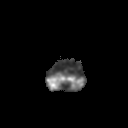

In [4]:
import cv2
from PIL import Image

image = Image.open('/home/keanuf/.cache/Assignemt9/BRAIN SEGMENTATION/dataset2/non-aug/test/353340_7.png')
mask = Image.open('/home/keanuf/.cache/Assignemt9/BRAIN SEGMENTATION/prediction,non-aug/353340_7.png')

result = Image.composite(image, Image.new('RGB', image.size, (0, 0, 0)), mask)


result.show()

In [5]:
import os
from PIL import Image

def composite_images(image_folder, mask_folder, output_folder):
    # Get the list of image files in the input folder
    image_files = os.listdir(image_folder)
    
    # Iterate through each image file
    for image_file in image_files:
        # Construct the file paths for the current image and its corresponding mask
        image_path = os.path.join(image_folder, image_file)
        mask_file = image_file.split('.')[0] + '.png'  # Assuming masks have the same filename format as images
        mask_path = os.path.join(mask_folder, mask_file)
        
        # Open the image and mask
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        # Perform composite operation
        result = Image.composite(image, Image.new('RGB', image.size, (0, 0, 0)), mask)
        
        # Construct the output file path
        output_file = os.path.join(output_folder, image_file)
        
        # Save the resulting composite image
        result.save(output_file)

# Paths to input image and mask folders, and output folder
image_folder = '/home/keanuf/.cache/Assignemt9/BRAIN SEGMENTATION/dataset2/non-aug/test'
mask_folder = '/home/keanuf/.cache/Assignemt9/BRAIN SEGMENTATION/prediction,non-aug'
output_folder = '/home/keanuf/.cache/BRAIN SEGMENTATOIN'

# Call the function to composite images and masks and save the results
composite_images(image_folder, mask_folder, output_folder)